In [1]:
import sys
sys.path.append("..")

from plotting_tools import * 

Max correlation between New infections of last 7 days and Shedding (of mean accross all simulations): 0.8432292037344825 at lag -64
Max correlation between New infections of last 7 days and Prevalence (of mean accross all simulations): 0.9701668898501535 at lag -53


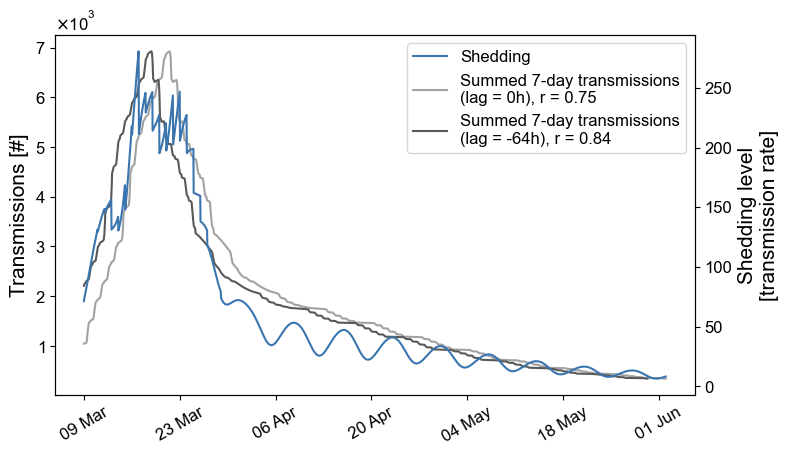

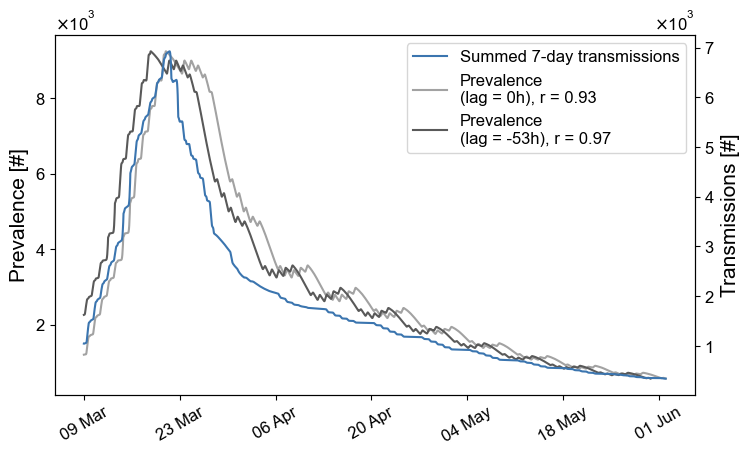

In [ ]:
num_sims = 100
result_file = 'pop8/'
max_lag = 720

# Read in first simulation to get the number of time points
output = pd.read_csv(result_file + f"0_output.csv", sep = " ")
output.columns = list(output.columns[1:]) + ['Unnamed']
output['t'] = output.index
output['Prevalence'] = output.E + output.Ins + output.Isy + output.Isev + output.Icri

num_time_points = len(output.t.unique())
prevalence = np.zeros((num_sims, num_time_points-24*7))
shedding = np.zeros((num_sims, num_time_points-24*7))
newInf_7day = np.zeros((num_sims, num_time_points-24*7))
corr = np.zeros((num_sims, 2 * (max_lag + 1)))
corr2 = np.zeros((num_sims, 2 * (max_lag + 1)))

prevalence[0, :] = output.Prevalence.iloc[24*7:] #only take prevalence and shedding from day 7 on
shedding[0, :] = output.Shedding.iloc[24*7:]
newInf_7day[0, :] = [output.NewInf.iloc[i:i+24*7].sum() for i in range(num_time_points-24*7)]
seven_day_df = pd.DataFrame()
seven_day_df['Prevalence'] = prevalence[0, :]
seven_day_df['Shedding'] = shedding[0, :]
seven_day_df['NewInf'] = newInf_7day[0, :]

for lag in range(-max_lag, max_lag + 1, 1):
    corr[0, lag + max_lag] = seven_day_df.Shedding.corr(seven_day_df.NewInf.shift(lag))
    corr2[0, lag + max_lag] = seven_day_df.NewInf.corr(seven_day_df.Prevalence.shift(lag))
    
for sim in range(1, num_sims):
    output = pd.read_csv(result_file + f"{sim}_output.csv", sep = " ")
    output.columns = list(output.columns[1:]) + ['Unnamed']
    output['t'] = output.index
    output['Prevalence'] = output.E + output.Ins + output.Isy + output.Isev + output.Icri
    prevalence[sim, :] = output.Prevalence.iloc[24*7:] #only take prevalence and shedding from day 7 on
    shedding[sim, :] = output.Shedding.iloc[24*7:]
    newInf_7day[sim, :] = [output.NewInf.iloc[i:i+24*7].sum() for i in range(num_time_points-24*7)]
    seven_day_df = pd.DataFrame()
    seven_day_df['Prevalence'] = prevalence[sim, :]
    seven_day_df['Shedding'] = shedding[sim, :]
    seven_day_df['NewInf'] = newInf_7day[sim, :]
    
    for lag in range(-max_lag, max_lag + 1, 1):
        corr[sim, lag + max_lag] = seven_day_df.Shedding.corr(seven_day_df.NewInf.shift(lag))
        corr2[sim, lag + max_lag] = seven_day_df.NewInf.corr(seven_day_df.Prevalence.shift(lag))
        
max_corr = corr.mean(axis=0).max()
lag_of_max_corr = list(corr.mean(axis=0)).index(max_corr) - max_lag
print(f"Max correlation between New infections of last 7 days and Shedding (of mean accross all simulations): {max_corr} at lag {lag_of_max_corr}")

max_corr2 = corr2.mean(axis=0).max()
lag_of_max_corr2 = list(corr2.mean(axis=0)).index(max_corr2) - max_lag
print(f"Max correlation between New infections of last 7 days and Prevalence (of mean accross all simulations): {max_corr2} at lag {lag_of_max_corr2}")

figsize = (8, 4.5)
panel = [0.08, 0.13, 0.8, 0.8] 
# Plot mean new inf and shedding with max lag
fig = plt.figure(figsize = figsize)
ax = fig.add_axes(panel)
ax2 = ax.twinx()
mean_vals_new_inf = newInf_7day.mean(axis=0)
mean_vals_shedding = shedding.mean(axis=0)
shifted_new_inf = np.zeros((num_sims, num_time_points - 24*7 - abs(lag_of_max_corr)))
if lag_of_max_corr < 0:
    shifted_new_inf[:, :] = newInf_7day[:, abs(lag_of_max_corr):]
else:
    shifted_new_inf[:, :] = newInf_7day[:, :-lag_of_max_corr]
mean_vals_shifted_new_inf = shifted_new_inf.mean(axis=0)
x = np.arange(num_time_points - 24*7)
x_shifted = np.arange(num_time_points - 24*7 - abs(lag_of_max_corr))
line1, = ax2.plot(x, mean_vals_shedding, color=colors['Blue'], label = 'Shedding')
line2, = ax.plot(x, mean_vals_new_inf, color=colors['Medium grey'], label=f'Summed 7-day transmissions\n(lag = 0h), r = {np.round(list(corr.mean(axis=0))[max_lag],2)}')
line3, = ax.plot(x_shifted, mean_vals_shifted_new_inf, color=colors['Dark grey'], label=f'Summed 7-day transmissions\n(lag = {lag_of_max_corr}h), r = {np.round(max_corr,2)}')
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper right')
xticks = np.arange(0, num_time_points - 24*7 , 14*24)
ax.set_xticks(xticks)
# Convert xlabels to dates starting from March 9
start_date = datetime(2020, 3, 9)
labels = [(start_date + timedelta(hours=int(i))).strftime('%d %b') for i in xticks]
# Set the labels
ax.set_xticklabels(labels, rotation=30)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((3, 3))  # Scientific notation for 1e5
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Transmissions [#]')
ax2.set_ylabel('Shedding level\n[transmission rate]')
plt.show()
fig.savefig(f'7-day_new_infections_shedding.png', dpi=dpi)

# Plot new infections and prevalence
fig = plt.figure(figsize = figsize)
ax = fig.add_axes(panel)
ax2 = ax.twinx()
mean_vals_prevalence = prevalence.mean(axis=0)
shifted_prevalence = np.zeros((num_sims, num_time_points - 24*7 - abs(lag_of_max_corr2)))
if lag_of_max_corr2 < 0:
    shifted_prevalence[:, :] = prevalence[:, abs(lag_of_max_corr2):]
else:
    shifted_prevalence[:, :] = prevalence[:, :-lag_of_max_corr2]
mean_vals_shifted_prevalence = shifted_prevalence.mean(axis=0)
x = np.arange(num_time_points - 24*7)
x_shifted = np.arange(num_time_points - 24*7 - abs(lag_of_max_corr2))
line1, = ax2.plot(x, mean_vals_new_inf, color=colors['Blue'], label = 'Summed 7-day transmissions')
line2, = ax.plot(x, mean_vals_prevalence, color=colors['Medium grey'], label=f'Prevalence\n(lag = 0h), r = {np.round(list(corr2.mean(axis=0))[max_lag],2)}')
line3, = ax.plot(x_shifted, mean_vals_shifted_prevalence, color=colors['Dark grey'], label=f'Prevalence\n(lag = {lag_of_max_corr2}h), r = {np.round(max_corr2,2)}')
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper right')
xticks = np.arange(0, num_time_points - 24*7, 14*24)
ax.set_xticks(xticks)
# Convert xlabels to dates starting from March 9
start_date = datetime(2020, 3, 9)
labels = [(start_date + timedelta(hours=int(i))).strftime('%d %b') for i in xticks]
# Set the labels
ax.set_xticklabels(labels, rotation=30)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((3, 3))  # Scientific notation for 1e5
ax.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Prevalence [#]')
ax2.set_ylabel('Transmissions [#]')
plt.show()
fig.savefig(f'7-day_new_infections_prevalence.png', dpi=dpi)